In [3]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from matplotlib import dates, rcParams, cycler
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from data_processing import ProcessData

# shh...
logging.getLogger().setLevel('INFO')

# dark theme
plt.style.use('dark_background')

# Set the default color cycle
color = ['#e84118', 'purple', 'orange', 'green', 'blue',]
rcParams['axes.prop_cycle'] = cycler(color=color) 

In [4]:
data_directory = 'data'
data_processor = ProcessData(data_directory)
data = data_processor.process()


/home/abhi/ECE143/ece143_data_analysis_project/data_processing.py:151: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stage_data = funds.groupby('stage').mean().sort_values(by='total_laid_off', ascending=False)


In [ ]:
# print(data)

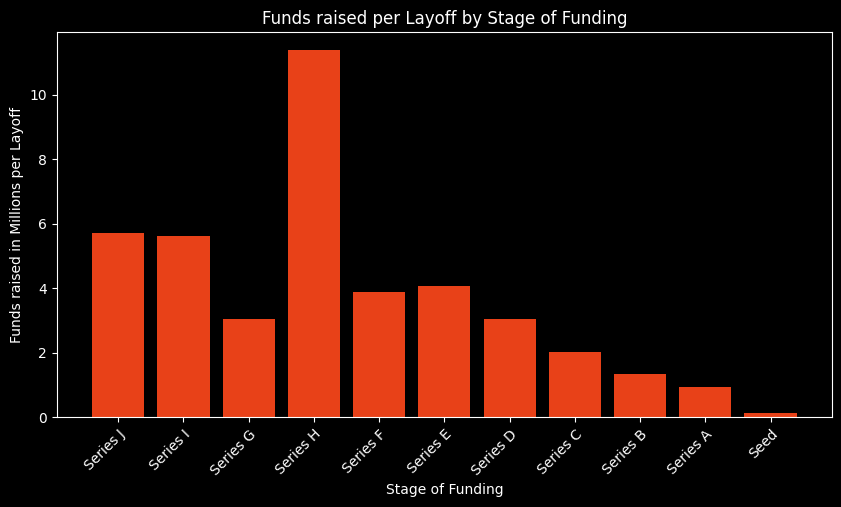

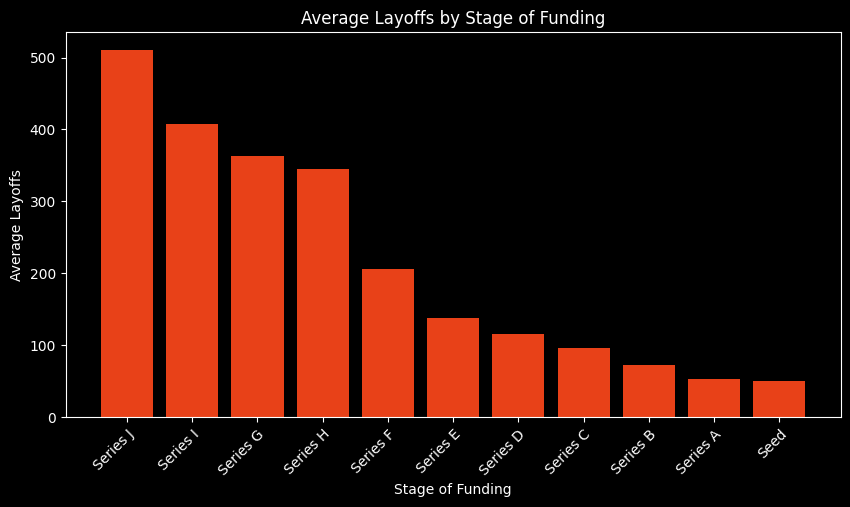

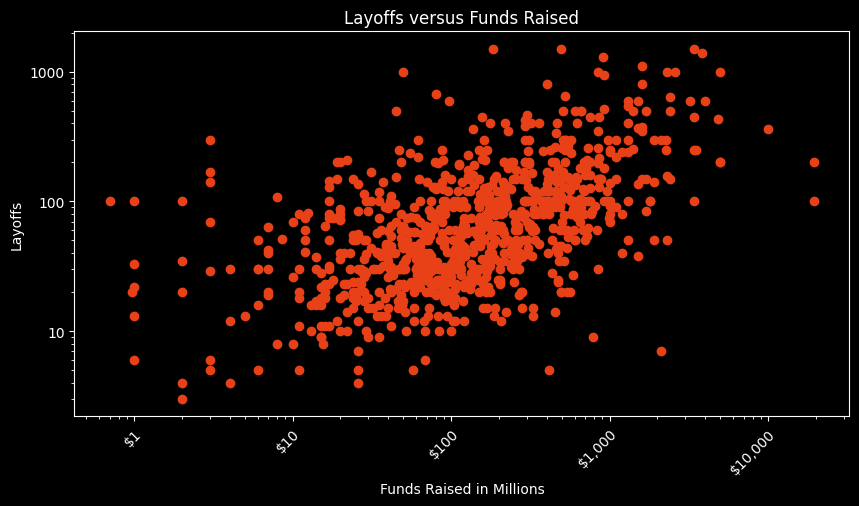

In [9]:
# Funding Plots
funding_data: pd.DataFrame = data['layoff_processed']['__company_funding_stage']
funding_raised_layoffs: pd.DataFrame = data['layoff_processed']['__company_funding_raised']
funding_raised_layoffs.dropna(inplace=True)

# Funds raised per Layoff by Stage
fig = plt.figure(figsize=(10, 5))
plt.bar(funding_data.index, funding_data['Funds raised per Layoff'])
plt.xlabel('Stage of Funding')
plt.ylabel('Funds raised in Millions per Layoff')
plt.title('Funds raised per Layoff by Stage of Funding')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

# Stage of Funding versus average layoffs
fig = plt.figure(figsize=(10, 5))
plt.bar(funding_data.index, funding_data['total_laid_off'])
plt.xlabel('Stage of Funding')
plt.ylabel('Average Layoffs')
plt.title('Average Layoffs by Stage of Funding')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

# Layoffs versus Funds Raised
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(funding_raised_layoffs['funds_raised'], funding_raised_layoffs['total_laid_off'])
plt.xlabel('Funds Raised in Millions')
plt.ylabel('Layoffs')
plt.xscale('log')
plt.yscale('log')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, loc: "${:,.0f}".format(float(x))))
ax.get_yaxis().set_major_formatter(ScalarFormatter())
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.title('Layoffs versus Funds Raised')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()


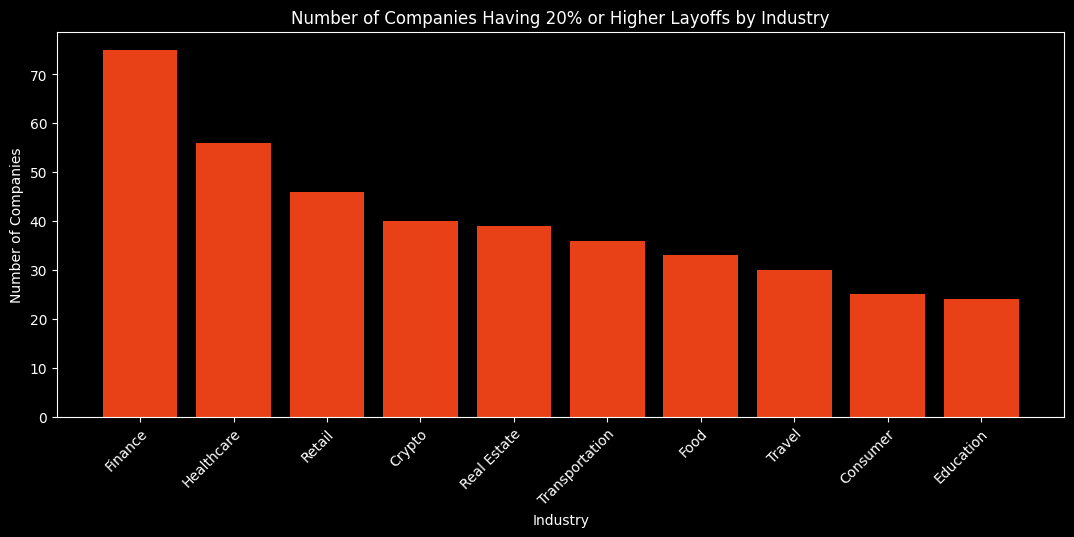

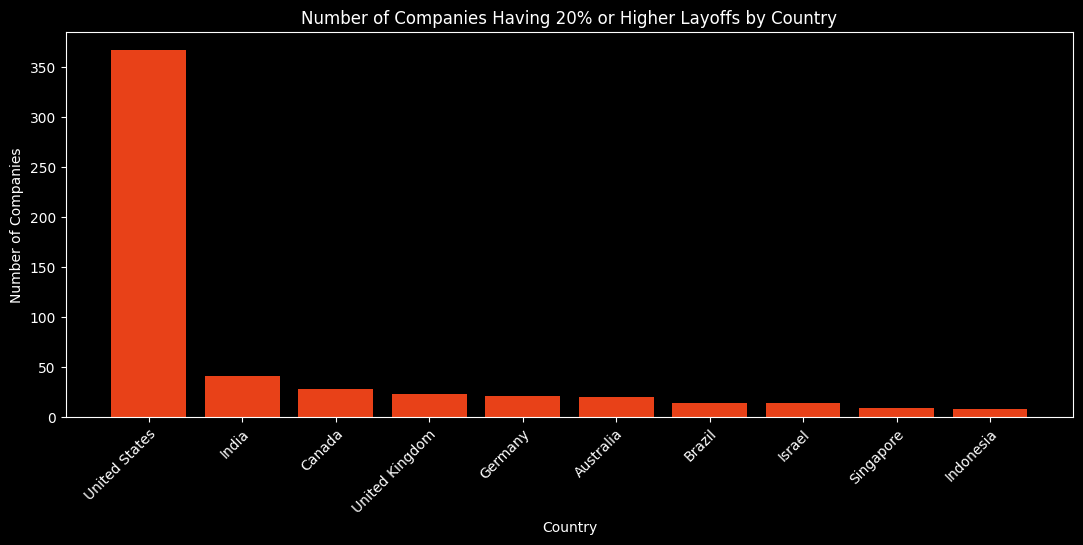

In [6]:
# Number of companies having >20% layoff in each industry
high_per_industry = data['layoff_processed']['__high_per_industry']
fig = plt.figure(figsize=(13, 5))
plt.bar(high_per_industry.index, high_per_industry['number of companies'], width=0.8)
plt.xlabel('Industry')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Having 20% or Higher Layoffs by Industry')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()


# Number of companies having >20% layoff in each country
high_per_country = data['layoff_processed']['__high_per_country']
fig = plt.figure(figsize=(13, 5))
plt.bar(high_per_country.index, high_per_country['number of companies'], width=0.8)
plt.xlabel('Country')
plt.ylabel('Number of Companies')
plt.title('Number of Companies Having 20% or Higher Layoffs by Country')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

**Plot Reasons for cut**

/tmp/ipykernel_21276/81973356.py:49: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animator = ani.FuncAnimation(fig, build_line_chart, interval = 1)


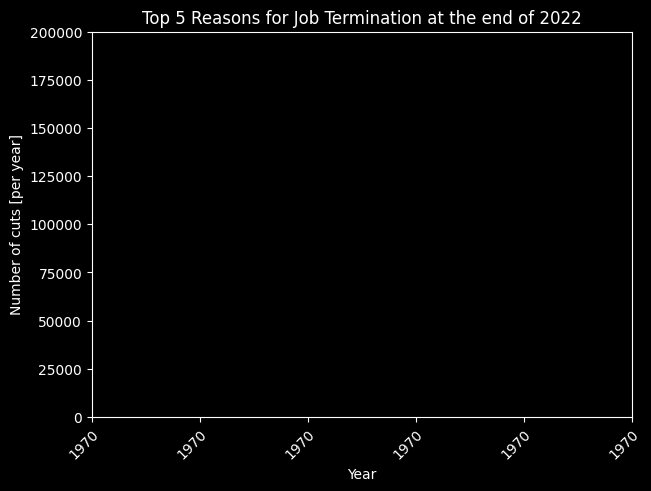

In [8]:
save_gif=False

reason_data = ProcessData('data/challenger_data')
reason_data = reason_data.process()
# print(reason_data['reason'].sort_values(by=[max(reason_data['reason'])],ascending=False))
to_plot_reason=(reason_data['reason']
         .sort_values(by=[max(reason_data['reason'])],ascending=False)
         .iloc[0:5].transpose()
        #  .reset_index().set_index('index')
         .sort_index(ascending=False)
         )
# print(to_plot_reason)

p_legend=[to_plot_reason.columns[i].replace('_',' ') + ': ' + str(to_plot_reason.iloc[0,i]) for i in range(len(to_plot_reason.columns))]
# print(p_legend)

# Year converts to YYYY/Jan/1, however the data is for the end of year.
to_plot_reason.index=pd.to_datetime(to_plot_reason.index,format='%Y')

# interpolate for smooth curve in plot
to_plot_reason=to_plot_reason.reindex(pd.date_range(min(to_plot_reason.index),pd.to_datetime('jan 2, 2022'),freq="D"))
# so tha endpoints of the plot are the values for 2022
to_plot_reason.iloc[-1]=to_plot_reason.iloc[-2] 
# Spline method drastically overshoots the data points
to_plot_reason=to_plot_reason.interpolate(method='polynomial',order=2)
# print(to_plot_reason)
to_plot_reason=to_plot_reason.reindex(pd.date_range(min(to_plot_reason.index),max(to_plot_reason.index),freq="37D"))
# to_plot=to_plot.sort_values(by=max(to_plot.index),axis=1,ascending=False)
# print(to_plot_reason)

# Plot parameters
color = ['orange', 'green', 'blue', 'purple','red',]
fig, ax = plt.subplots(constrained_layout=True)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor") #rotate the x-axis values
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
plt.ylabel('Number of cuts [per year]')
plt.xlabel('Year')
plt.title('Top 5 Reasons for Job Termination at the end of 2022')

# Plot builder for animation
def build_line_chart(i=int):
    # color = ['#e84118', 'purple', 'orange', 'green', 'blue',]
    plt.legend(p_legend, loc='upper left')
    p = plt.plot(to_plot_reason[:i].index, to_plot_reason[:i].values) #note it only returns the dataset, up to the point i
    # for i in range(0,len(color)):
    #     p[i].set_color(color[i]) #set the colour of each curve

# animator takes a minute
animator = ani.FuncAnimation(fig, build_line_chart, interval = 1)
plt.ylim([0, 200000])
if save_gif:
    # PillowWriter doesn't control loop count yet. Have to modify externally
    # because  looping makes this plot useless.
    animator.save('plots/reasons.gif', dpi=300, writer=ani.PillowWriter(fps=20))
else:
    # doesn't show animation in jupyter
    plt.show()
plt.close()